## 주간 지하철 이용자 객수(코로나 확산 이후)

### 1. 데이터 전처리

In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [3]:
pq = spark.read.parquet('metro_per_date')
pq.show()

+----------+------+------------+------------+------------+--------+
|  사용일자|노선명|        역명|승차총승객수|하차총승객수|이용자수|
+----------+------+------------+------------+------------+--------+
|2018-01-10|분당선|압구정로데오|       16346|       18420|   34766|
|2018-01-10|분당선|      서울숲|        7914|        7922|   15836|
|2018-01-10|분당선|        수원|        9461|        6280|   15741|
|2018-01-10|분당선|        수서|       15403|       15627|   31030|
|2018-01-10|분당선|  대모산입구|        3431|        3182|    6613|
|2018-01-10|분당선|      개포동|        3582|        3723|    7305|
|2018-01-10|분당선|        구룡|        2105|        2005|    4110|
|2018-01-10|분당선|        도곡|        7855|        8147|   16002|
|2018-01-10|분당선|        한티|       16276|       17214|   33490|
|2018-01-10|분당선|        선릉|       10792|       22141|   32933|
|2018-01-10|과천선|        범계|       32318|       30961|   63279|
|2018-01-10|과천선|        평촌|       19691|       19258|   38949|
|2018-01-10|과천선|      인덕원|       28817|       28564|   57381|
|2018-01-10|

In [4]:
import pyspark.sql.types as T
import pyspark.sql.functions as F

In [5]:
#사용일자를 2월1일로 바꿈
df = pq.where(pq.사용일자>'2020-01-06').orderBy(F.asc('`사용일자`'))
df.show()

+----------+------+----------------------+------------+------------+--------+
|  사용일자|노선명|                  역명|승차총승객수|하차총승객수|이용자수|
+----------+------+----------------------+------------+------------+--------+
|2020-01-07| 2호선|                한양대|       10179|       10770|   20949|
|2020-01-07| 2호선|                  시청|       30647|       29322|   59969|
|2020-01-07| 2호선|      왕십리(성동구청)|       19087|       15781|   34868|
|2020-01-07| 1호선|                동대문|       12450|       12843|   25293|
|2020-01-07| 1호선|                동묘앞|        6090|        6291|   12381|
|2020-01-07| 2호선|             을지로4가|       14987|       14441|   29428|
|2020-01-07| 2호선|              상왕십리|       15752|       15295|   31047|
|2020-01-07| 1호선|                  시청|       28129|       28050|   56179|
|2020-01-07| 1호선|               종로5가|       28447|       27705|   56152|
|2020-01-07| 1호선|                제기동|       17678|       17677|   35355|
|2020-01-07| 1호선|청량리(서울시립대입구)|       21460|       21728|   43188|

In [6]:
df = df.select("사용일자", "승차총승객수")
df.show()

+----------+------------+
|  사용일자|승차총승객수|
+----------+------------+
|2020-01-07|        1813|
|2020-01-07|       56932|
|2020-01-07|       28129|
|2020-01-07|       49608|
|2020-01-07|       32831|
|2020-01-07|       28447|
|2020-01-07|       12450|
|2020-01-07|       15945|
|2020-01-07|       17678|
|2020-01-07|       21460|
|2020-01-07|        6090|
|2020-01-07|       30647|
|2020-01-07|       56020|
|2020-01-07|       26809|
|2020-01-07|       14987|
|2020-01-07|       16222|
|2020-01-07|       15025|
|2020-01-07|       15752|
|2020-01-07|       19087|
|2020-01-07|       10179|
+----------+------------+
only showing top 20 rows



In [7]:
#주별로 나누기위해 판다스로 변환
weekly_df = df.select("*").toPandas()
weekly_df

,사용일자,승차총승객수
0,2020-01-07,1813
1,2020-01-07,56932
2,2020-01-07,28129
3,2020-01-07,49608
4,2020-01-07,32831
...,...,...
377374,2021-09-30,28562
377375,2021-09-30,9859
377376,2021-09-30,9308
377377,2021-09-30,6389


In [8]:
#사용일자 컬럼이 string이라서 datetime 데이터타입으로 변환해줘야함.
import numpy as np
import pandas as pd
weekly_df['사용일자'] = pd.to_datetime(weekly_df['사용일자'])
weekly_df.dtypes

사용일자      datetime64[ns]
승차총승객수             int32
dtype: object

In [9]:
#사용일자 컬럼을 일별에서 주별로 나누어 변환함.
weekly_df = weekly_df.resample('w-mon', on='사용일자').승차총승객수.sum().reset_index()
weekly_df

,사용일자,승차총승객수
0,2020-01-13,51210906
1,2020-01-20,51766720
2,2020-01-27,37274813
3,2020-02-03,45239198
4,2020-02-10,43106598
...,...,...
86,2021-09-06,38017487
87,2021-09-13,38915705
88,2021-09-20,35178269
89,2021-09-27,30632894


In [10]:
#주별로 계산할때 한주씩 밀려서 일주일씩 빼야함.
from datetime import datetime, timedelta
weekly_df["사용일자"] = weekly_df['사용일자'] - timedelta(days=7)
weekly_df

,사용일자,승차총승객수
0,2020-01-06,51210906
1,2020-01-13,51766720
2,2020-01-20,37274813
3,2020-01-27,45239198
4,2020-02-03,43106598
...,...,...
86,2021-08-30,38017487
87,2021-09-06,38915705
88,2021-09-13,35178269
89,2021-09-20,30632894


In [11]:
#마지막 행 필요없으므로 삭제(10월1일,2일 데이터가 없으므로)
weekly_df = weekly_df.drop(90, axis=0)
weekly_df

,사용일자,승차총승객수
0,2020-01-06,51210906
1,2020-01-13,51766720
2,2020-01-20,37274813
3,2020-01-27,45239198
4,2020-02-03,43106598
...,...,...
85,2021-08-23,37077195
86,2021-08-30,38017487
87,2021-09-06,38915705
88,2021-09-13,35178269


In [12]:
#parqeut 저장 시 사용일자에 시간이 뜨는 오류가 생겨서 string으로 데이터타입 변환
weekly_df = weekly_df.astype({"사용일자" : 'str'})
weekly_df.dtypes

사용일자      object
승차총승객수     int32
dtype: object

In [13]:
weekly_df

,사용일자,승차총승객수
0,2020-01-06,51210906
1,2020-01-13,51766720
2,2020-01-20,37274813
3,2020-01-27,45239198
4,2020-02-03,43106598
...,...,...
85,2021-08-23,37077195
86,2021-08-30,38017487
87,2021-09-06,38915705
88,2021-09-13,35178269


In [14]:
#parquet 저장
weekly_df.to_parquet("metro_per_week.parquet")

In [15]:
#parquet 파일 확인
pq = spark.read.parquet('metro_per_week.parquet')
pq.show()

+----------+------------+-----------------+
|  사용일자|승차총승객수|__index_level_0__|
+----------+------------+-----------------+
|2020-01-06|    51210906|                0|
|2020-01-13|    51766720|                1|
|2020-01-20|    37274813|                2|
|2020-01-27|    45239198|                3|
|2020-02-03|    43106598|                4|
|2020-02-10|    45354541|                5|
|2020-02-17|    41549862|                6|
|2020-02-24|    31072502|                7|
|2020-03-02|    30928877|                8|
|2020-03-09|    31240762|                9|
|2020-03-16|    32227520|               10|
|2020-03-23|    32907278|               11|
|2020-03-30|    33426691|               12|
|2020-04-06|    34455083|               13|
|2020-04-13|    32771421|               14|
|2020-04-20|    37360899|               15|
|2020-04-27|    33043966|               16|
|2020-05-04|    36543135|               17|
|2020-05-11|    38632631|               18|
|2020-05-18|    39848296|               19

## 2. 그래프 확인

In [16]:
#그래프 예시
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

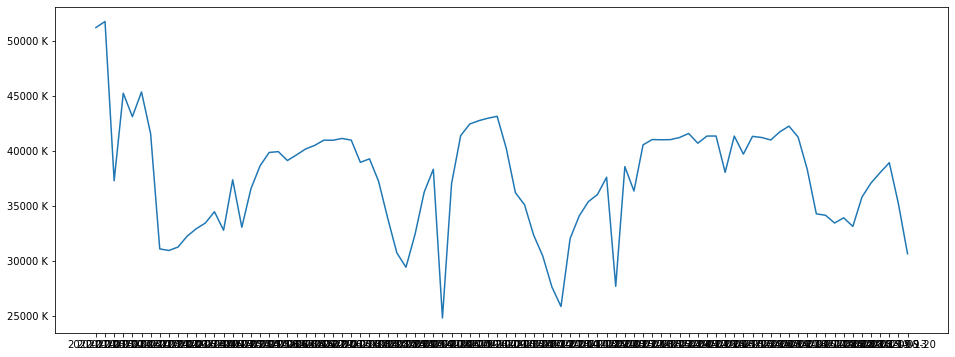

In [18]:
plt.figure(figsize=(16,6))
plt.plot(weekly_df['사용일자'], weekly_df['승차총승객수']/1000)
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%i K'))
plt.show()